In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from tqdm.auto import tqdm
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
from src.features.vectorizer import get_glove_vectorizer

glove_vectorizer = get_glove_vectorizer(maxlen=40)

Loading pretrained Glove
[==================================================] 100.0% 758.5/758.5MB downloaded
Done


In [11]:
from src.data.data_module import TextDataModule
from src.features.preprocess import preprocess
from nltk.tokenize import word_tokenize

dm = TextDataModule(vectorizer_fn=glove_vectorizer,
                    preprocess_fn=preprocess,
                    tokenize_fn=word_tokenize)

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
import torchmetrics

class LSTMClassifier(pl.LightningModule):
    def __init__(self, embedding_dim, h_dim, n_classes,
                 bidirectional=False):
        super().__init__()
        
        self.bidirectional = bidirectional
        self.lstm = nn.LSTM(embedding_dim, h_dim, 
                            batch_first=True,
                            bidirectional=True)
        D = 2 if bidirectional else 1
        self.fc = nn.Linear(h_dim * D, n_classes)
        
        self.accuracy = torchmetrics.Accuracy()
        
    def forward(self, x):
        N = x.shape[0]
        _, (hn, _) = self.lstm(x)
        # Shape (D, batch, h_dim) -> (batch, D * h_dim)
        x = hn.permute(1, 0, 2).reshape(N, -1)
        x = self.fc(x)
        return x
    
    def training_step(self, batch, batch_idx):
        x, y = batch["feat"].float(), batch["labels"]
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        acc = self.accuracy(y_hat, y)
        self.log("train/loss", loss)
        self.log("train/acc", acc)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch["feat"].float(), batch["labels"]
        y_hat = self(x)
        val_loss = F.cross_entropy(y_hat, y)
        acc = self.accuracy(y_hat, y)
        self.log("val/loss", val_loss)
        self.log("val/acc", acc)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

# x = torch.randn(128, 64, 200)
# print(x.dtype)
model = LSTMClassifier(200, 20, 3, bidirectional=True)

early_stopping = pl.callbacks.EarlyStopping('val/acc', patience=10, mode='max')
logger = pl.loggers.TensorBoardLogger("lightning_logs", name="lstm-glove")
trainer = pl.Trainer(callbacks=[early_stopping], accelerator="gpu", logger=logger)
trainer.fit(model=model, datamodule=dm)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type     | Params
--------------------------------------
0 | lstm     | LSTM     | 35.5 K
1 | fc       | Linear   | 123   
2 | accuracy | Accuracy | 0     
--------------------------------------
35.6 K    Trainable params
0         Non-trainable params
35.6 K    Total params
0.143     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

ValueError: Caught ValueError in DataLoader worker process 3.
Original Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/_utils/worker.py", line 287, in _worker_loop
    data = fetcher.fetch(index)
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 49, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 49, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataset.py", line 398, in __getitem__
    return self.dataset[self.indices[idx]]
  File "/notebooks/aml-challenge-3/src/data/dataset.py", line 43, in __getitem__
    x = self.vectorizer_fn(text)
  File "/notebooks/aml-challenge-3/src/features/vectorizer.py", line 29, in transform
    x = np.vstack(x)
  File "<__array_function__ internals>", line 180, in vstack
  File "/opt/conda/lib/python3.8/site-packages/numpy/core/shape_base.py", line 282, in vstack
    return _nx.concatenate(arrs, 0)
  File "<__array_function__ internals>", line 180, in concatenate
ValueError: need at least one array to concatenate


24.0

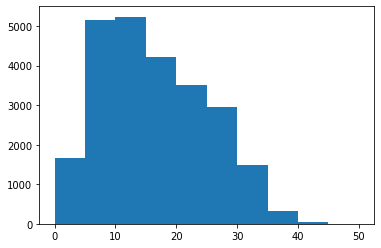

In [77]:
import matplotlib.pyplot as plt
import numpy as np
lens = []
for x, _ in tqdm(dm.subsets["train_full"]):
    lens.append(len(x))

plt.hist(lens,range=(0, 50))
np.quantile(lens, 0.8)